Step 2. 데이터 전처리하기  
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.  

Step 3. SubwordTextEncoder 사용하기  
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.  

Step 4. 모델 구성하기  
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.  

Step 5. 모델 평가하기  
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

# 한국어 챗봇 모델 구축

## Step 1. 데이터 준비

원본 데이터셋 (`ChatbotData.csv`)을 사용하여 한국어 챗봇 모델을 구축합니다.

## Step 2. 데이터 전처리

한국어 데이터에 맞게 전처리 함수를 정의하고 질문-답변 쌍 데이터셋을 로드합니다.

In [47]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np

# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거 - 한국어에는 소문자 변환이 크게 의미 없을 수 있지만, 일관성을 위해 유지
  sentence = str(sentence).lower().strip() # Ensure input is string and lower case (for consistency)

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  # 한국어 구두점 및 특수문자 처리 강화
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # 한글, 영어 알파벳, 숫자, 그리고 기본적인 구두점(., ?, !, ,)만 남기고 모두 공백으로 대체
  sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  inputs, outputs = [], []
  with open('ChatbotData.csv', 'r', encoding='utf-8') as file:
    lines = file.readlines()
    # Skip the header row and handle potential empty lines or malformed rows
    for line in lines[1:]:
      parts = line.strip().split(',')
      # Ensure there are at least 3 columns and the question and answer are not empty
      if len(parts) >= 3 and parts[1].strip() and parts[2].strip():
        inputs.append(preprocess_sentence(parts[1]))
        outputs.append(preprocess_sentence(parts[2]))

        # Use a reasonable MAX_SAMPLES if defined, otherwise load all
        if 'MAX_SAMPLES' in globals() and len(inputs) >= MAX_SAMPLES:
            return inputs, outputs
  return inputs, outputs

# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11819
전체 샘플 수 : 11819


## Step 3. SubwordTextEncoder 사용하기

형태소 분석기 대신 SubwordTextEncoder를 사용하여 한국어 데이터를 토크나이징합니다.

In [48]:
# 사용할 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

print("SubwordTextEncoder를 사용하여 Vocabulary를 생성합니다.")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
# target_vocab_size를 사용하여 단어장의 크기를 제한할 수 있습니다.
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print('단어장의 크기 :', (VOCAB_SIZE))


# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    # SubwordTextEncoder의 encode는 이미 [UNK] 토큰 처리를 포함합니다.
    sentence1_encoded = [START_TOKEN[0]] + tokenizer.encode(sentence1) + [END_TOKEN[0]]
    sentence2_encoded = [START_TOKEN[0]] + tokenizer.encode(sentence2) + [END_TOKEN[0]]

    # 최대 길이 MAX_LENGTH 이하인 경우에만 데이터셋으로 허용
    if len(sentence1_encoded) <= MAX_LENGTH and len(sentence2_encoded) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1_encoded)
      tokenized_outputs.append(sentence2_encoded)

  # 최대 길이 MAX_LENGTH로 모든 데이터셋을 패딩
  # padding='post'는 시퀀스 뒤에 0을 채웁니다.
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post', value=0) # Explicitly set padding value to 0
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post', value=0) # Explicitly set padding value to 0

  return tokenized_inputs, tokenized_outputs

questions_tokenized, answers_tokenized = tokenize_and_filter(questions, answers)

print('필터링 및 토큰화 후 질문 샘플 개수: {}'.format(len(questions_tokenized)))
print('필터링 및 토큰화 후 답변 샘플 개수: {}'.format(len(answers_tokenized)))

# tf.data.Dataset 구성 (튜플 구조 사용)
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    (questions_tokenized, answers_tokenized[:, :-1]), # Inputs tuple: (inputs, dec_inputs)
    answers_tokenized[:, 1:]                          # Outputs tensor
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print("\nDataset 구성 완료 (튜플 구조).")

SubwordTextEncoder를 사용하여 Vocabulary를 생성합니다.
단어장의 크기 : 7936
필터링 및 토큰화 후 질문 샘플 개수: 11819
필터링 및 토큰화 후 답변 샘플 개수: 11819

Dataset 구성 완료 (튜플 구조).


## Step 4. 모델 구성하기

트랜스포머 모델을 구현합니다. 인코더와 디코더 구조를 포함합니다.

In [49]:
# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(tf.cast(10000, tf.float32), (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    # Explicitly convert to dense tensor and cast to float32
    inputs = tf.cast(tf.sparse.to_dense(inputs) if isinstance(inputs, tf.SparseTensor) else inputs, tf.float32)
    # Dynamically slice positional encoding based on input shape
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 패딩 마스크 생성 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 룩어헤드 마스크 생성 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

# 인코더 레이어 함수
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 인코더 함수
def encoder(
            vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs", dtype=tf.int32)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask", dtype=tf.float32)

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model, dtype=tf.float32)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 디코더 레이어 함수
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 디코더 함수
def decoder(
            vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs', dtype=tf.int32)
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs', dtype=tf.float32)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask', dtype=tf.float32)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask', dtype=tf.float32)

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model, dtype=tf.float32)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 트랜스포머 모델 함수
def transformer(
                vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs", dtype=tf.int32)
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs", dtype=tf.int32)

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask', dtype=tf.float32)(inputs)

  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask', dtype=tf.float32)(dec_inputs)

  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask', dtype=tf.float32)(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs", dtype=tf.float32)(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

# 하이퍼파라미터 설정
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

tf.keras.backend.clear_session()

# 모델 생성
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_padding_mask    │ (None, 1, 1,      │          0 │ inputs[0][0]      │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, None, 256) │  3,085,824 │ inputs[0][0],     │
│ (Functional)        │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ look_ahead_mask     │ (None, 1, None,   │          0 │ dec_inputs[0][0]  │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_padding_mask    │ (None, 1, 1,      │          0 │ inputs[0][0]      │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, None, 256) │  3,613,184 │ dec_inputs[0][0], │
│ (Functional)        │                   │            │ encoder[0][0],    │
│                     │                   │            │ look_ahead_mask[… │
│                     │                   │            │ dec_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Dense)     │ (None, None,      │  2,039,552 │ decoder[0][0]     │
│                     │ 7936)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,738,560 (33.33 MB)

 Trainable params: 8,738,560 (33.33 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5. 모델 평가 및 추론 함수

학습된 모델을 사용하여 입력 문장에 대한 답변을 생성하는 함수를 구현합니다.

In [75]:
# 예측(인퍼런스) 함수
def decoder_inference(sentence, repetition_penalty=1.0):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장.
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # Keep track of generated token IDs in the current output sequence
  generated_token_ids = set(tf.squeeze(output_sequence, axis=0).numpy())

  # 디코더의 인퍼런스 단계 (최대 길이까지 반복)
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :] # 마지막 토큰에 대한 예측값만 가져오기

    # Get the logits for the current step
    logits = tf.squeeze(predictions, axis=0) # Shape: (1, vocab_size) -> (vocab_size,)

    # Apply repetition penalty for already generated tokens in this output sequence
    if repetition_penalty != 1.0:
        # Create a mask for generated tokens
        # Use tf.one_hot to create a one-hot representation of generated tokens
        # Then sum along axis 0 to get a mask where generated tokens have a value > 0
        # Cast the result to boolean
        generated_mask = tf.cast(tf.reduce_sum(tf.one_hot(list(generated_token_ids), depth=VOCAB_SIZE), axis=0), dtype=tf.bool)

        # Apply penalty: reduce logits for generated tokens
        # Use multiplication in logit space
        logits = tf.where(generated_mask, logits * repetition_penalty, logits)

        # Alternative: Set logit to a large negative value multiplied by penalty (more aggressive)
        # large_negative = -1e9
        # logits = tf.where(generated_mask, large_negative * repetition_penalty, logits)


    # Get the predicted token ID from the (potentially penalized) logits
    predicted_id = tf.cast(tf.argmax(tf.expand_dims(logits, axis=0), axis=-1), tf.int32)

    # If the predicted token is already in the generated set (and not an end token),
    # apply a harsher penalty or resample. For simplicity here, we'll rely on the logit penalty.
    # A more robust approach might involve resampling if the top prediction is a repeated token.

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # Add the predicted token ID to the set of generated tokens
    # Ensure the predicted_id is a scalar integer before adding to the set
    generated_token_ids.add(predicted_id.numpy().item())

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

# 답변 생성 함수 (uses the modified decoder_inference)
def sentence_generation(sentence, repetition_penalty=1.0):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence, repetition_penalty)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  # 토큰화되지 않은 패딩 값(0)은 디코딩에서 제외합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

# 테스트 문장으로 답변 생성 확인
test_sentences = [
    "오늘 기분이 어때?",
    "배고파 죽겠어",
    "심심해",
    "내일 뭐 할까?",
    "고마워"
]

for sentence in test_sentences:
    sentence_generation(sentence, repetition_penalty=1.9)

입력 : 오늘 기분이 어때?
출력 : 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 세상에서 


KeyboardInterrupt: 

# LMS

평가문항	상세기준
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.	공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.	구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.
3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.	한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.

In [1]:
import tensorflow

print(tensorflow.__version__)

2.16.1


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(tf.cast(10000, tf.float32), (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    # Ensure inputs are float32
    inputs = tf.cast(inputs, tf.float32)
    # Dynamically slice positional encoding based on input shape
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

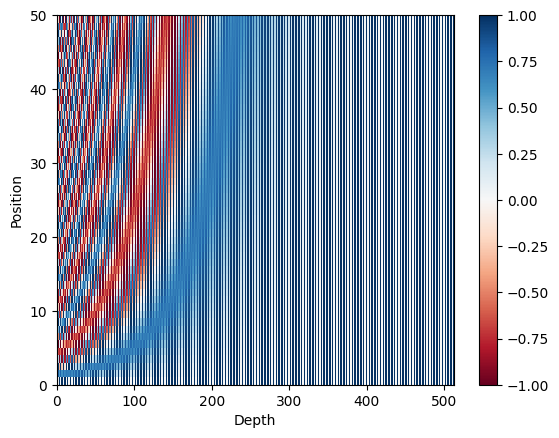

In [4]:
sample_pos_encoding = PositionalEncoding(50,512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [5]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [7]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [8]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [9]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [10]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # Positional Encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [11]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [12]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # Positional Encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [13]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [14]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-히?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [15]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  inputs, outputs = [], []
  with open('ChatbotData.csv', 'r', encoding='utf-8') as file:
    lines = file.readlines()
    # Skip the header row
    for line in lines[1:]: # Assuming the first row is a header
      parts = line.strip().split(',') # Assuming comma separated values
      # Assuming question is in the second column (index 1) and answer in the third (index 2)
      if len(parts) >= 3 and parts[1] and parts[2]: # Ensure both question and answer exist and are not empty
        inputs.append(preprocess_sentence(parts[1]))
        outputs.append(preprocess_sentence(parts[2]))

        if len(inputs) >= MAX_SAMPLES:
          return inputs, outputs
  return inputs, outputs

In [16]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11819
전체 샘플 수 : 11819


In [17]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 다음 달에는 더 절약해봐요 .
전처리 후의 22번째 답변 샘플: 


In [18]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐


In [19]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [20]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [7906]
END_TOKEN의 번호 : [7907]


In [21]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

7908


In [22]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [810, 6873, 4, 4685, 1]
정수 인코딩 후의 21번째 답변 샘플: []


In [23]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [24]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [25]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 7908
필터링 후의 질문 샘플 개수: 11819
필터링 후의 답변 샘플 개수: 11819


In [26]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [28]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

TypeError: Exception encountered when calling PositionalEncoding.call().

[1mCould not automatically infer the output shape / dtype of 'positional_encoding' (of type PositionalEncoding). Either the `PositionalEncoding.call()` method is incorrect, or you need to implement the `PositionalEncoding.compute_output_spec() / compute_output_shape()` method. Error encountered:

Expected float32, but got SparseTensor(indices=Tensor("Placeholder_1:0", shape=(None, 3), dtype=int64), values=Tensor("Placeholder:0", shape=(None,), dtype=float32), dense_shape=Tensor("PlaceholderWithDefault:0", shape=(3,), dtype=int64)) of type 'SparseTensor'.[0m

Arguments received by PositionalEncoding.call():
  • args=('<KerasTensor shape=(None, None, 256), dtype=float32, sparse=True, ragged=False, name=keras_tensor_4>',)
  • kwargs=<class 'inspect._empty'>

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence